# Compose: Training a model to generate music

In [1]:
import os
import pickle
import numpy
import pydot
from matplotlib import pyplot
from music21 import note, chord

from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import plot_model
from keras import regularizers

from models.RNNAttention import get_distinct, create_lookups, prepare_sequences, get_music_list, create_network, create_network_gru

Using TensorFlow backend.


## Set parameters

In [2]:
# run params
section = 'compose'
run_id = 'GRU_baseline'
genre_name = 'jazz'
composer_name='JohnColtrane'

run_folder = 'run/{}/{}/'.format(section, genre_name)
run_folder += '_'.join([run_id, composer_name])


store_folder = os.path.join(run_folder, 'store')
data_folder = os.path.join('data', genre_name, composer_name)

if not os.path.exists(run_folder):
    os.mkdir(run_folder)
    os.mkdir(os.path.join(run_folder, 'store'))
    os.mkdir(os.path.join(run_folder, 'output'))
    os.mkdir(os.path.join(run_folder, 'weights'))
    os.mkdir(os.path.join(run_folder, 'viz'))
    


mode = 'load' # 'load' # 

# data params
intervals = range(1)
seq_len = 32

# model params
embed_size = 100
rnn_units = 256
use_attention = True
reg = None
#reg = regularizers.l2(0.03)
#reg = regularizers.l1_l2(l1=0.01,l2=0.01)
learning_rate = 0.001

## Extract the notes

In [3]:
data_folder

'data/jazz/JohnColtrane'

In [5]:
if mode == 'build':
    
    music_list, parser = get_music_list(data_folder)
    print(len(music_list), 'files in total')

    notes = []
    durations = []

    for i, file in enumerate(music_list):
        print(i+1, "Parsing %s" % file)
        original_score = parser.parse(file).chordify()
        

        for interval in intervals:

            score = original_score.transpose(interval)

            #notes.extend(['START'] * seq_len)
            #durations.extend([0]* seq_len)
            notes.extend(['START'])
            durations.extend([0])

            for element in score.flat:
                
                if isinstance(element, note.Note):
                    if element.isRest:
                        notes.append(str(element.name))
                        durations.append(element.duration.quarterLength)
                    else:
                        notes.append(str(element.nameWithOctave))

                if isinstance(element, chord.Chord):
                    notes.append('.'.join(n.nameWithOctave for n in element.pitches))
                    durations.append(element.duration.quarterLength)

    with open(os.path.join(store_folder, 'notes'), 'wb') as f:
        pickle.dump(notes, f) #['G2', 'D3', 'B3', 'A3', 'B3', 'D3', 'B3', 'D3', 'G2',...]
    with open(os.path.join(store_folder, 'durations'), 'wb') as f:
        pickle.dump(durations, f)
else:
    with open(os.path.join(store_folder, 'notes'), 'rb') as f:
        notes = pickle.load(f) #['G2', 'D3', 'B3', 'A3', 'B3', 'D3', 'B3', 'D3', 'G2',...]
    with open(os.path.join(store_folder, 'durations'), 'rb') as f:
        durations = pickle.load(f) 

## Create the lookup tables

In [6]:
# get the distinct sets of notes and durations
note_names, n_notes = get_distinct(notes)
duration_names, n_durations = get_distinct(durations)
#velocity_names, n_velocities = get_distinct(velocities)
distincts = [note_names, n_notes, duration_names, n_durations]

with open(os.path.join(store_folder, 'distincts'), 'wb') as f:
    pickle.dump(distincts, f)

# make the lookup dictionaries for notes and dictionaries and save
note_to_int, int_to_note = create_lookups(note_names)
duration_to_int, int_to_duration = create_lookups(duration_names)
#velocity_to_int, int_to_velocity = create_lookups(velocity_names)
lookups = [note_to_int, int_to_note, duration_to_int, int_to_duration]

with open(os.path.join(store_folder, 'lookups'), 'wb') as f:
    pickle.dump(lookups, f)

In [7]:
print('\nnote_to_int')
note_to_int


note_to_int


{'A2': 0,
 'A2.B2': 1,
 'A2.F#3': 2,
 'A2.F3': 3,
 'A3': 4,
 'A3.B-3': 5,
 'A3.B3': 6,
 'A3.C#4': 7,
 'A3.C4': 8,
 'A3.D4': 9,
 'A3.E-4': 10,
 'A3.F4': 11,
 'A3.G4': 12,
 'A4': 13,
 'A4.B-4': 14,
 'A4.B-4.B4': 15,
 'A4.B-4.C5': 16,
 'A4.B4': 17,
 'A4.B4.C#5': 18,
 'A4.C#5': 19,
 'A4.C5': 20,
 'A4.D5': 21,
 'A4.E-5': 22,
 'A5': 23,
 'A5.B-5': 24,
 'A5.B5': 25,
 'A5.C6': 26,
 'B-2': 27,
 'B-2.B2': 28,
 'B-2.C3': 29,
 'B-2.D3': 30,
 'B-2.F#3': 31,
 'B-2.F#4': 32,
 'B-2.F3': 33,
 'B-3': 34,
 'B-3.B3': 35,
 'B-3.C#4': 36,
 'B-3.C4': 37,
 'B-3.D4': 38,
 'B-3.E-4': 39,
 'B-3.F#4': 40,
 'B-3.F#4.G4': 41,
 'B-3.F4': 42,
 'B-3.G#4': 43,
 'B-3.G4': 44,
 'B-4': 45,
 'B-4.B4': 46,
 'B-4.C#5': 47,
 'B-4.C5': 48,
 'B-4.D5': 49,
 'B-4.E-5': 50,
 'B-5': 51,
 'B-5.B5': 52,
 'B2': 53,
 'B2.B3': 54,
 'B2.C#3': 55,
 'B2.C#5': 56,
 'B2.C3': 57,
 'B2.C5': 58,
 'B2.D3': 59,
 'B2.F3': 60,
 'B2.G3': 61,
 'B3': 62,
 'B3.A4': 63,
 'B3.C#4': 64,
 'B3.C4': 65,
 'B3.C5': 66,
 'B3.D4': 67,
 'B3.E-4': 68,
 'B3.E4': 69

In [8]:
print('\nduration_to_int')
duration_to_int


duration_to_int


{0: 0,
 Fraction(1, 12): 1,
 Fraction(1, 6): 2,
 0.25: 3,
 Fraction(1, 3): 4,
 Fraction(5, 12): 5,
 0.5: 6,
 Fraction(7, 12): 7,
 Fraction(2, 3): 8,
 0.75: 9,
 Fraction(5, 6): 10,
 Fraction(11, 12): 11,
 1.0: 12,
 Fraction(13, 12): 13,
 Fraction(7, 6): 14,
 1.25: 15,
 Fraction(4, 3): 16,
 Fraction(17, 12): 17,
 1.5: 18,
 Fraction(19, 12): 19,
 Fraction(5, 3): 20,
 1.75: 21,
 Fraction(11, 6): 22,
 Fraction(23, 12): 23,
 2.0: 24,
 Fraction(25, 12): 25,
 Fraction(13, 6): 26,
 2.25: 27,
 Fraction(7, 3): 28,
 Fraction(29, 12): 29,
 2.5: 30,
 Fraction(31, 12): 31,
 Fraction(8, 3): 32,
 2.75: 33,
 Fraction(17, 6): 34,
 Fraction(35, 12): 35,
 3.0: 36,
 Fraction(19, 6): 37,
 3.25: 38,
 Fraction(10, 3): 39,
 3.5: 40,
 Fraction(43, 12): 41,
 Fraction(11, 3): 42,
 3.75: 43,
 Fraction(23, 6): 44,
 4.0: 45,
 Fraction(49, 12): 46,
 4.25: 47,
 Fraction(13, 3): 48,
 Fraction(53, 12): 49,
 4.5: 50,
 Fraction(14, 3): 51,
 4.75: 52,
 5.0: 53,
 5.25: 54,
 5.5: 55,
 5.75: 56,
 6.0: 57,
 6.25: 58,
 Fraction(

## Prepare the sequences used by the Neural Network

In [9]:
network_input, network_output = prepare_sequences(notes, durations, lookups, distincts, seq_len)

In [10]:
print('pitch input')
print(network_input[0][0])
print('duration input')
print(network_input[1][0])
print('pitch output')
print(network_output[0][0])
print('duration output')
print(network_output[1][0])

pitch input
[307 196 141 244 244 293  13 293 244 150 141  13 142 141 244  13 294 293
  13 294 293 141 244 196 293 302 270  13  13  13  13 293]
duration input
[ 0 30 12  9  9  8 28  4  6  2 13 14  1  5 36 13  2  2  5  1  5  4 15  3
  3  1  2 38 12  8 12  6]
pitch output
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.


## Create the structure of the neural network

In [12]:
model, att_model = create_network_gru(n_notes, n_durations, embed_size, rnn_units, use_attention, reg, learning_rate)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 100)    30800       input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 100)    6700        input_2[0][0]                    
____________________________________________________________________________________________

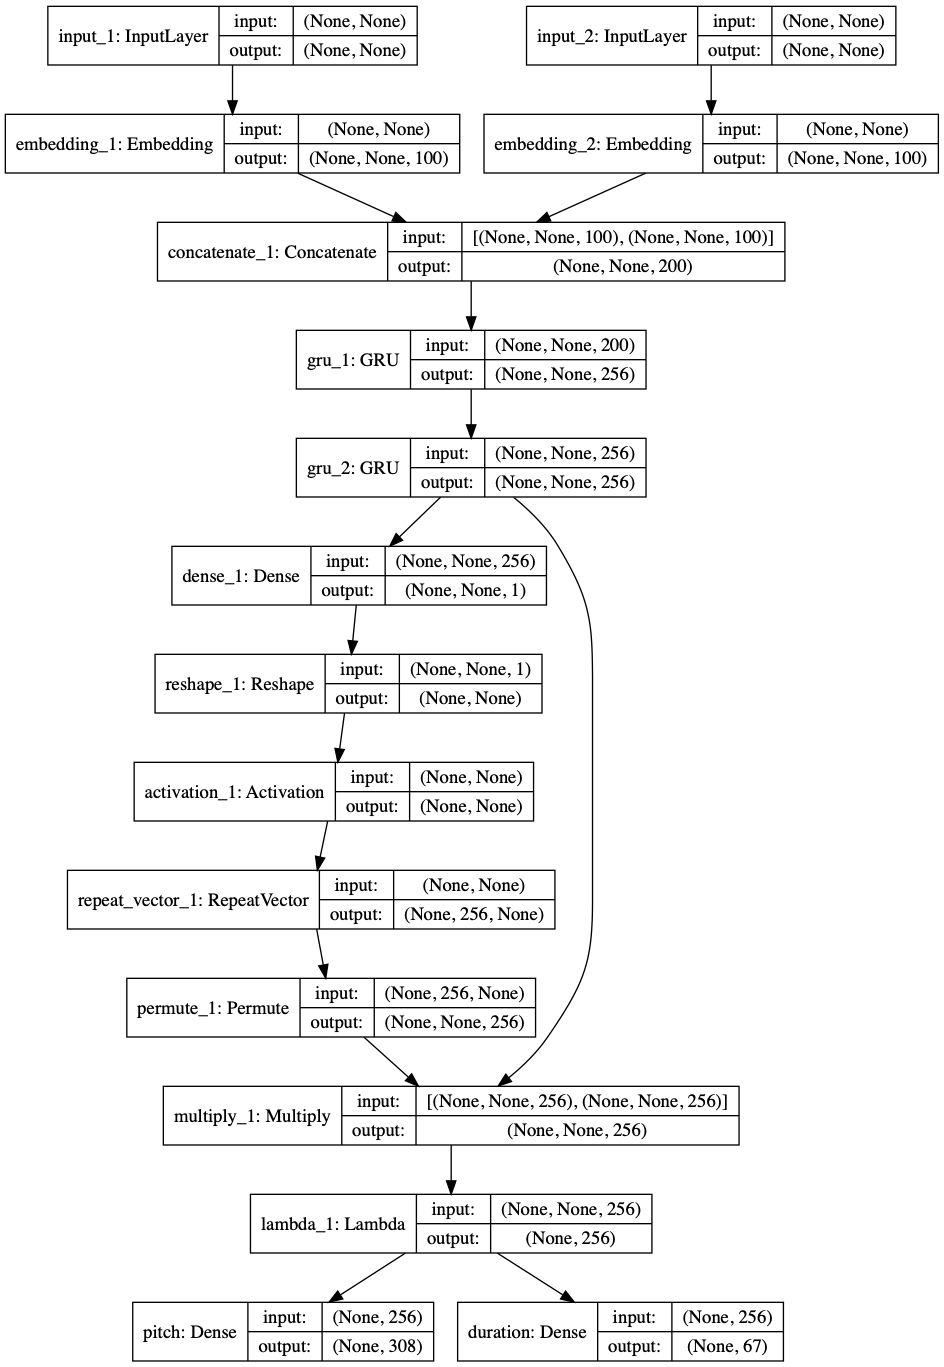

In [13]:
plot_model(model, to_file=os.path.join(run_folder ,'viz/model.png'), show_shapes = True, show_layer_names = True)

## Train the neural network

In [14]:
weights_folder = os.path.join(run_folder, 'weights')
# model.load_weights(os.path.join(weights_folder, "weights.h5"))

In [15]:
weights_folder = os.path.join(run_folder, 'weights')

checkpoint1 = ModelCheckpoint(
    os.path.join(weights_folder, "weights-improvement-{epoch:02d}-{loss:.4f}-bigger.h5"),
    monitor='loss',
    verbose=0,
    save_best_only=True,
    mode='min'
)

checkpoint2 = ModelCheckpoint(
    os.path.join(weights_folder, "weights.h5"),
    monitor='loss',
    verbose=0,
    save_best_only=True,
    mode='min'
)

early_stopping = EarlyStopping(
    monitor='val_loss'
    , restore_best_weights=True
    , patience = 10
)


callbacks_list = [
    checkpoint1
    , checkpoint2
    , early_stopping
 ]

model.save_weights(os.path.join(weights_folder, "weights.h5"))
history = model.fit(network_input, network_output
          , epochs=1000, batch_size=32
          , validation_split = 0.2
          , callbacks=callbacks_list
          , shuffle=True
         )

train_history = history.history['loss']
val_history = history.history['val_loss']



/Users/weiliang/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 16464 samples, validate on 4117 samples
Epoch 1/1000
16464/16464 [==============================] - 165s 10ms/step - loss: 6.0122 - pitch_loss: 3.7985 - duration_loss: 2.2141 - val_loss: 5.9195 - val_pitch_loss: 4.0478 - val_duration_loss: 1.8732
Epoch 2/1000
16464/16464 [==============================] - 157s 10ms/step - loss: 5.7546 - pitch_loss: 3.5932 - duration_loss: 2.1609 - val_loss: 5.8426 - val_pitch_loss: 4.0544 - val_duration_loss: 1.7904
Epoch 3/1000
16464/16464 [==============================] - 165s 10ms/step - loss: 5.5889 - pitch_loss: 3.4441 - duration_loss: 2.1448 - val_loss: 5.7549 - val_pitch_loss: 4.0044 - val_duration_loss: 1.7524
Epoch 4/1000
16464/16464 [==============================] - 156s 9ms/step - loss: 5.4694 - pitch_loss: 3.3454 - duration_loss: 2.1239 - val_loss: 5.5898 - val_pitch_loss: 3.8516 - val_duration_loss: 1.7396
Epoch 5/1000
16464/16464 [==============================] - 184s 11ms/step - loss: 5.3647 - pitch_loss: 3.2740 - duration_lo

16464/16464 [==============================] - 365s 22ms/step - loss: 1.2049 - pitch_loss: 0.8774 - duration_loss: 0.3277 - val_loss: 9.9920 - val_pitch_loss: 5.8560 - val_duration_loss: 4.1430
Epoch 41/1000
10720/16464 [==================>...........] - ETA: 1:55 - loss: 1.0841 - pitch_loss: 0.7964 - duration_loss: 0.2877

KeyboardInterrupt: 

In [ ]:
pyplot.plot(train_history, color='blue', label='train')
pyplot.plot(val_history, color='orange', label='validation')
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='lower left')
pyplot.show()